<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 1 ISPR 2023 - Assignment 6 - Salvatore Correnti (m. 584136)
In this assignment we will show the implementation and testing on different images of an image blob detector based on the `Laplacian of Gaussian` convolution filter.

## Initial imports
Before coding, we use a single cell for changing working directory to the one in which this notebook is contained and for all the imports for simplyfing reading.

In [1]:
%cd ./drive/MyDrive/Github/ISPR-Midterms-2023

/content/drive/MyDrive/Github/ISPR-Midterms-2023


In [102]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2 # for converting BGR -> grayscale
from scipy.signal import convolve2d as scipy_convolve2d # 2d-convolution operator
from scipy.ndimage import gaussian_laplace
from skimage.exposure import rescale_intensity as scipy_rescale_intensity
from PIL import Image
from typing import * # for function signatures

## Definition and Implementation of LoG
We first define the `Laplacian of Gaussian` operator as the sum of the diagonal elements of the Jacobian matrix of the Gaussian function:

$$g_{\sigma}(x, y) := \dfrac{1}{2\pi\sigma^2}e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}$$.

$$\nabla g_{\sigma}(x, y) = -\dfrac{g_{\sigma}(x,y)}{\sigma^2}\left[\begin{array}{c} x \\ y \end{array}\right]$$

$$\nabla^2g_{\sigma}(x,y) = \dfrac{\partial^2 g_{\sigma}}{\partial x^2} + \dfrac{\partial^2 g_{\sigma}}{\partial y^2} = \dfrac{e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}}{\pi\sigma^4}\left[\dfrac{x^2 + y^2}{2\sigma^2} - 1\right]\:\:(1)$$


As we can see in (1), the sign of $\nabla^2 g_{\sigma}$ is determined by the value of $x^2 + y^2$, which can be interpreted as the radius of a circle centered in $(0, 0)$ to which $(x, y)$ belongs, and in particular $\nabla^2 g_{\sigma}$ when this radius is equal to $\sigma\sqrt{2}$, for which in fact the $\nabla^2 g_{\sigma}$ used as convolutional filter has the maximum response.

Sometimes the Laplacian of Gaussian is used in its `normalized` form:

$$ \nabla^2_{norm}g_{\sigma}(x, y) := \sigma^2\nabla^2g_{\sigma}(x,y)$$

The normalized form has the effect to maintain a higher diversity in pixel values after the convolution.

Since we are operating with discrete values like images, we need to define a `kernel`, which is a matrix $M \in \mathbb{R^{(2n+1) \times (2n+1)}}$ such that $M_{n+1 \pm i, n+1 \pm j} = f(\pm i, \pm j)$ for a given function $f$.

In [3]:
def log_filter(window_size: int, sigma: float = 1.0, normalized=False):
  """
  :param window_size: Size of the kernel window.
  :param sigma: Variance (sigma) of the LoG filter.
  """
  w1 = h1 = window_size // 2  # In case of odd window, will give 0 to central value
  w2 = h2 = window_size - w1
  x, y = np.arange(-w1, w2, 1), np.arange(-h1, h2, 1)
  mg = np.meshgrid(x, y)
  # Compute the (x^2+y^2/(2sigma^2)) matrix
  r = (np.square(mg[0][:, :]) + np.square(mg[1][:, :]))/(2 * sigma**2)
  # Now compute the exp(r) matrix
  gs = np.exp(-r)
  exponent = 2 if normalized else 4
  result = 1.0/(np.pi * sigma**exponent) * (gs * (r - 1.0)) # * for elementwise product
  return result.astype(np.float32)

We now consider also the `Difference of Gaussian` approximation:

In [4]:
def gaussian_filter(window_size: int, sigma: float=1.0):
  """
  :param window_size: Size of the kernel window.
  :param sigma: Variance (sigma) of the LoG filter.
  """
  w1 = h1 = window_size // 2  # In case of odd window, will give 0 to central value
  w2 = h2 = window_size - w1
  x, y = np.arange(-w1, w2, 1), np.arange(-h1, h2, 1)
  mg = np.meshgrid(x, y)
  # Compute the (x^2+y^2/(2sigma^2)) matrix
  r = -(np.square(mg[0][:, :]) + np.square(mg[1][:, :]))/(2 * sigma**2)
  # Now compute the exp(r) matrix
  gs = np.exp(r)
  result = 1.0/(2 * np.pi * sigma**2) * gs
  return result.astype(np.float32)

In [5]:
def dog_filter(window_size: int, sigma0: float = 1.0, kappa: int = 1.0):
  u = gaussian_filter(window_size, (kappa+1)*sigma0)
  v = gaussian_filter(window_size, sigma0)
  return (u - v)/(kappa * sigma0**2)

An example of LoG matrix for a 3x3 kernel (both non-normalized and normalized):

In [6]:
print("Non-normalized kernel: ")
print(log_filter(3, 2.0))
print("Normalized kernel: ")
print(log_filter(3, 2.0, True))
print("Approximated kernel: ")
print(dog_filter(3, 1.0, 2))

Non-normalized kernel: 
[[-0.01162031 -0.01536213 -0.01162031]
 [-0.01536213 -0.01989437 -0.01536213]
 [-0.01162031 -0.01536213 -0.01162031]]
Normalized kernel: 
[[-0.04648125 -0.06144851 -0.04648125]
 [-0.06144851 -0.07957747 -0.06144851]
 [-0.04648125 -0.06144851 -0.04648125]]
Approximated kernel: 
[[-0.0213628  -0.03990206 -0.0213628 ]
 [-0.03990206 -0.07073553 -0.03990206]
 [-0.0213628  -0.03990206 -0.0213628 ]]


## Dataset
For performing convolutions we will use the following dataset:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

Since its whole dimension is of about 125 MB, (by now) the whole dataset is stored in the same folder of this notebook.

We will now define some utilities for our task:

In [7]:
def load_image(dir_path: str, file_name: str):
  return Image.open(os.path.join(dir_path, file_name)).convert('L')

def get_image_array(arr: np.ndarray, show=False):
  image = Image.fromarray(arr, mode='L')
  if show:
    image.show()
  return image

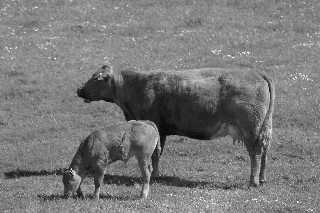

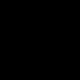

In [36]:
img = load_image('MSRC_ObjCategImageDatabase_v1', '1_9_s.bmp')
img.show()

print()

# Just to check that get_image_array works correctly
black_image_arr = np.zeros((80, 80), np.uint8)
pil_black_image = get_image_array(black_image_arr, True)

After that, we define utility functions to use to compare the output of the convolution and of the `LoG` operator to assess correctness of our implementations.

In [37]:
def cv2_convolver(src, kernel):
  """
  A wrapper function for `cv2.filter2D` to conform
  to the `convolver` argument of `convolve_image`.
  """
  out = cv2.filter2D(src, -1, kernel)
  return out

In [38]:
def scipy_convolver(src, kernel):
  """
  A wrapper function for `scipy.signal.convolve2d` to
  conform to the `convolver` argument of `convolve_image`.
  """
  return scipy_convolve2d(src, kernel, mode='same')

In [39]:
def log_scipy(img, sigma, radius=None):
  """
  LoG convolution as implemented by scipy in order
  to make comparisons.
  """
  img_arr = np.asarray(img, dtype=np.uint8)
  result = gaussian_laplace(img_arr, sigma, radius=(radius-1)//2)
  return result

Finally, we define a utility function to use with all convolvers so far to operate either with `Pillow` images or `numpy` arrays.

In [124]:
def convolve_image(
    image: Union[Image.Image, np.ndarray], kernel: np.ndarray,
    convolver: Callable[[np.ndarray, np.ndarray], np.ndarray]=scipy_convolve2d,
    rescale_intensity=False, to_uint8=True,
):
  # Cannot specify in the signature that image is either Image or numpy
  # (Does not recognize Union annotation)
  """
  Given a grayscale PIL image, converts it to array and convolves
  it with the given kernel.
  :param image: PIL Image or numpy array to be convolved.
  :param kernel: numpy kernel to use for convolution.
  :param convolver: Function of the form (img, kernel) -> conv_img to use
  for performing convolution. Defaults to `scipy.signal.convolve2d`.
  :return: Convolved image as np.uint8 array.
  """
  if isinstance(image, Image.Image):
    img_arr = np.asarray(image).astype(np.float32)  # It is better to actually convolve with double values
  elif isinstance(image, np.ndarray):
    img_arr = image
  else:
    raise TypeError(f"Unknown input type '{type(image)}' for 'image' parameter.")
  conv_img = convolver(img_arr, kernel)
  if rescale_intensity:
    conv_img = scipy_rescale_intensity(conv_img, (0, 1))
    conv_img = 255 * conv_img
  if to_uint8:
    conv_img = conv_img.astype(np.uint8)
  return conv_img

Before proceeding, let's do a couple of comparisons between our `LoG` implementation and the one provided by `scipy.ndimage.gaussian_laplacian`, and between the non-normalized and the normalized filters.

float32
-100.17973 8.718492
-100.17973 8.718492


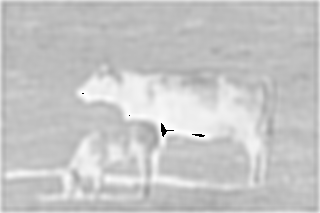

In [98]:
# First normalized LoG
kernel = log_filter(15, 4, True)
conv_image = convolve_image(img, kernel, convolver=scipy_convolver)
pil_conv_image = get_image_array(conv_image, True)

float32
-6.2612333 0.5449057
-6.2612333 0.5449057


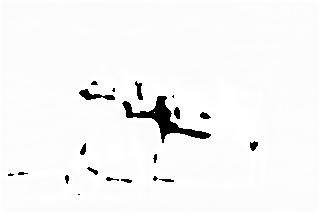

In [101]:
# Then, non-normalized one (as the one used by scipy)
kernel = log_filter(15, 4)
conv_image = convolve_image(img, kernel, convolver=scipy_convolver)
pil_conv_image = get_image_array(conv_image, True)

We now compare with the LoG by `scipy`.

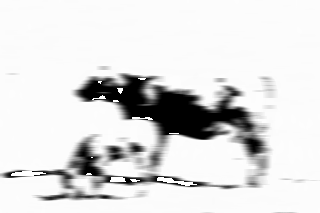

In [46]:
conv_image = log_scipy(img, 4, 15)
pil_conv_image = get_image_array(conv_image, True)

## Convolution
We now manually define our convolver for 2D-images.

First, we must notice that the convolution is actually defined by pairwise multiplication **not** on the kernel matrix "untouched", but with a *swapped* version of it: given matrices $M \in \mathbb{R}^{m \times n}, K \in \mathbb{R}^{(2k+1) \times (2k+1)}$, it holds:

$$\left(M * K\right)_{ij} := \sum_{p = -k}^{k}{\sum_{q = -k}^{k}{M_{i+p, j+q}K_{k+1-p, k+1-q}}}$$

where for simplicity we define $M_{\alpha,\beta} = 0, K_{\alpha, \beta} = 0$ whenever $\alpha < 0 \vee \beta < 0$.

Our first step is then to define a function that applies that swapping:

In [47]:
def swap_matrix(mat: np.ndarray):
  if len(mat.shape) != 2:
    raise ValueError("'mat' parameter must be a np.ndarray with shape of size 2")
  m, n = mat.shape[-2:]
  for i in range(m):
    mat[i, :] = mat[i, ::-1]
  for j in range(n):
    mat[:, j] = mat[::-1, j]
  return mat

Now just test that all works correctly:

In [48]:
mat = np.random.randn(4, 4)
mat

array([[-0.47867246, -0.44283982,  2.39078355,  0.05485167],
       [-0.46159522, -0.56459604, -0.75383256,  0.1359772 ],
       [ 0.74578474, -0.56612619,  2.56393792,  1.34725313],
       [-1.0835105 , -2.07678346, -0.64537355,  0.54918161]])

In [49]:
swap_matrix(mat)
mat

array([[ 0.54918161, -0.64537355, -2.07678346, -1.0835105 ],
       [ 1.34725313,  2.56393792, -0.56612619,  0.74578474],
       [ 0.1359772 , -0.75383256, -0.56459604, -0.46159522],
       [ 0.05485167,  2.39078355, -0.44283982, -0.47867246]])

We now define our convolution function. Before proceeding, it must be noted that for simplicity our function will implement **only** the *same* mode for convolutions: this is because we want to maintain the same dimension of the input image in the output one, and we want to center the kernel on the given point in the image at each step since we are calculating `LoG` for detecting blobs.

We now define some helper functions for code readability and for easier debugging:



In [50]:
def get_offsets(k: int):
  """
  Given a kernel size k, returns the offsets on all directions
  for calculating the position of the kernel in the image.
  """
  left_width_offset = up_height_offset = k // 2 # According to our construction of kernel
  right_width_offset = down_height_offset = k - (k // 2) # Including center
  return left_width_offset, right_width_offset, up_height_offset, down_height_offset

In [51]:
def get_kernel_indexes(i: int, j: int, m: int, n: int, k: int):
  """
  Given indexes of the current point in the image, size of the image
  and size of the kernel, calculates the indexes to use for selecting
  the sub-matrix of the kernel to use in current iteration.
  :param i: Row index of the current image point.
  :param j: Column index of the current image point.
  :param m: Row dimension of the image.
  :param n: Column dimension of the image.
  :param k: Dimension of the kernel.
  """
  left_width_offset, right_width_offset, up_height_offset, down_height_offset = get_offsets(k)
  kernel_column_start = max(0, left_width_offset - j)
  kernel_column_end = left_width_offset + min(right_width_offset, n - j)
  kernel_row_start = max(0, up_height_offset - i)
  kernel_row_end = up_height_offset + min(down_height_offset, m - i)
  return kernel_row_start, kernel_row_end, kernel_column_start, kernel_column_end

In [52]:
def get_image_indexes(i, j, m, n, k):
  """
  Given indexes of the current point in the image, size of the image
  and size of the kernel, calculates the indexes to use for selecting
  the sub-matrix of the image to use in current iteration.
  :param i: Row index of the current image point.
  :param j: Column index of the current image point.
  :param m: Row dimension of the image.
  :param n: Column dimension of the image.
  :param k: Dimension of the kernel.
  """
  left_width_offset, right_width_offset, up_height_offset, down_height_offset = get_offsets(k)
  image_column_start = max(0, j - left_width_offset)
  image_column_end = min(n, j + right_width_offset)
  image_row_start = max(0, i - up_height_offset)
  image_row_end = min(m, i + down_height_offset)
  return image_row_start, image_row_end, image_column_start, image_column_end

Finally, here is our convolution function:

In [53]:
def convolve2d(image: np.ndarray, kernel: np.ndarray, pad_value=0.0):
  """
  Applies a 2d-convolution between the given image and
  the given kernel with padding.
  :param image: Image to convolve as numpy array.
  :param kernel: Kernel to use for convolution as 2d numpy array.
  :param pad_value: Value to use for padding. Defaults to 0.
  :return: Convolved image as numpy array.
  """
  # First, copy kernel matrix to swap
  swap_kernel = kernel.copy()
  swap_matrix(swap_kernel)
  
  output = np.full(image.shape, pad_value, dtype=kernel.dtype)
  m, n = image.shape[-2:]  # m rows, n columns
  k = len(kernel)  # size of the kernel matrix
  for i in range(m):
    for j in range(n):
      # Extract submatrix from kernel for applying convolution
      kernel_row_start, kernel_row_end, kernel_column_start, kernel_column_end = get_kernel_indexes(i, j, m, n, k)
      kernel_submatrix = swap_kernel[kernel_row_start:kernel_row_end, kernel_column_start:kernel_column_end]
      # Now extract submatrix from image
      image_row_start, image_row_end, image_column_start, image_column_end = get_image_indexes(i, j, m, n, k)
      image_submatrix = image[image_row_start:image_row_end, image_column_start:image_column_end]
      # Now multiply the submatrices element-wise to get the current output item
      output[i, j] = np.sum(image_submatrix * kernel_submatrix)
  return output

Now let's test correctness of our implementation. First, visually compare with the above results, then calculate the difference in norm for that image and a randomly generated one:

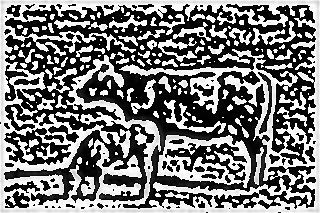

In [143]:
kernel = log_filter(35, 2, True)
conv_image = convolve_image(img, kernel, convolver=convolve2d)
pil_conv_image = get_image_array(conv_image, True)

In [56]:
kernel = log_filter(15, 4, True)
random_img = np.random.randint(0, 255, (200, 160)).astype(np.uint8)
scipy_conv_random_img = convolve_image(random_img, kernel, convolver=scipy_convolver)
own_conv_random_img = convolve_image(random_img, kernel, convolver=convolve2d)
print(np.linalg.norm(scipy_conv_random_img - own_conv_random_img))

0.0


In [58]:
kernel = log_filter(15, 4, False)
random_img = np.random.randint(0, 255, (200, 160)).astype(np.uint8)
scipy_conv_random_img = convolve_image(random_img, kernel, convolver=scipy_convolver)
own_conv_random_img = convolve_image(random_img, kernel, convolver=convolve2d)
print(np.linalg.norm(scipy_conv_random_img - own_conv_random_img))

0.0


Now some time comparisons:

In [59]:
%timeit convolve2d(np.asarray(img), kernel)
%timeit cv2.filter2D(np.asarray(img), -1, kernel)
%timeit scipy_convolve2d(np.asarray(img), kernel)

1.1 s ± 278 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.87 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
60.6 ms ± 969 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Local Maxima detection
After having implemented and tested our 2D convolution, the subsequent step is to detect local maxima in the image produced by the convolution: this is because `LoG` filter has the maximum response when centered around a homogeneous region of radius $\approx \sigma\sqrt{2}$, hence if a given point $(x,y)$ is on the center of that region, its value will be a local maximum in the ball $\mathcal{B}\left((x, y), \sigma\sqrt{2}\right)$.

In our case, since we are operating in a discrete approximation of the continous space $\mathbb{R}^2$, we can simplify this detection by testing on a squared window of size $\left\lfloor{\sigma}\right\rfloor$: in fact, if $p_0 := (x_0, y_0)$ is the center of such a window $W(p_0)$, for any point $p := (x, y)$ it holds that $\|p - p_0\|^2 = (x-x_0)^2 + (y-y_0)^2 \leq 2\sigma^2$, hence $W(p_0) \subset \mathcal{B}\left((x, y), \sigma\sqrt{2}\right)$.

For capturing all local maxima, we need to cycle over the entire image: our next step will be to implement this algorithm.

In [ ]:
def get_argmax(arr: np.ndarray):
  """
  Given a 2-dimensional array `arr`, returns the
  indexes (i, j) s.t. arr[i, j] = arr.max().
  """
  if len(arr.shape) != 2:
    raise ValueError("'arr' parameter must be a 2-dimensional array")
  height_argmax = np.argmax(arr, axis=1)
  i = np.argmax(arr[np.arange(len(arr)), height_argmax])
  j = height_argmax[i]
  return i, j

In [174]:
def local_maxima_finder(
    image: np.ndarray, sigma: float, kernel_size: int,
    thresholder: Callable[[np.ndarray], Any] = lambda x: x.mean().item()-1,
    result: np.ndarray = None,
    # maxima: dict[tuple[int, int], tuple[int, float]] = None
):
  """
  :param image: numpy array of the image.
  :param sigma: sigma value for `log_filter`.
  :param kernel_size: Size of the kernel used for convolution. 
  :return: A numpy matrix which contains -1 for all elements
  which are not local maxima and the pixel value for all local
  maxima. If `result` is not None, stores the computed values
  in the given array.
  """
  # TODO Is that correct? May we assume to deal also with negative values??
  if result is None:
    result = np.full(image.shape, -1, dtype=np.intc)
  radius = math.floor(sigma)
  if radius <= 1.0:
    raise ValueError("Too small radius, all points in the image will be local maxima!")
  m, n = image.shape[-2:]
  for i in range(m):
    for j in range(n):
      row_start, row_end, column_start, column_end = get_image_indexes(i, j, m, n, kernel_size)
      max_value = np.max(image[row_start:row_end, column_start:column_end]).item()
      if image[i, j] >= max_value:
        result[i, j] = image[i, j]
        # Filtering for identical values
        for p in range(row_start, row_end):
          for q in range(column_start, column_end):
            if image[p, q] >= max_value:
              image[p, q] = 0  # Will not take it also as maximum (almost)
  threshold_value = thresholder(result[result > -1])
  result[result < threshold_value] = -1
  return result

An example:

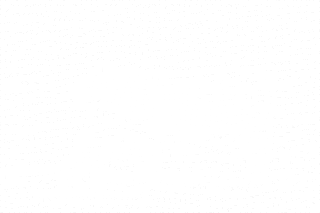

Number of local maxima found: 2614 (3.8351% of the pixels in the image)


In [175]:
sigma = 2
kernel_size = 9
kernel = log_filter(kernel_size, sigma)
conv_image = convolve_image(img, kernel, convolver=convolve2d)
result = local_maxima_finder(conv_image, sigma, kernel_size, thresholder=lambda x: 1).astype(np.uint8)
pil_conv_image = get_image_array(result, True)
num_local_maxima = len(result[result < 255])
print(f"Number of local maxima found: {num_local_maxima} ({100 * num_local_maxima / np.prod(conv_image.shape):.4f}% of the pixels in the image)")

## Maximizing over the scaling dimension
After having found the local maxima in the so-called *`spatial dimension`*, to complete the blob detection we need to compare the results for different values of $\sigma$, keeping only the best one for each pixel across *all* of them: this is called maximization over the *`scaling dimension`*.

We will use different values of $\sigma$, e.g. the set $\{2^n\:|\:0 \leq n \leq C\}$ for some constant $C$. Varying across a wide range for $\sigma$ is important to detect both small and large blobs (?).

In [158]:
def total_maxima_finder(
    image: np.ndarray, sigmas: list[float], kernel_size: int,
    normalize_kernels=True, convolver=scipy_convolver,
    thresholder=lambda x: x.mean().item()
):
  points = []
  # Sort sigmas in reverse order to make sure that when using np.argmax()
  # we take the result with the highest sigma value (hence the highest radius)
  sigmas = sorted(sigmas, reverse=True)
  m, n = image.shape[-2:]
  results = np.full((len(sigmas), m, n), -1, dtype=np.intc)
  for i in range(len(sigmas)):
    sigma = sigmas[i]
    kernel = log_filter(kernel_size, sigma, normalize_kernels)
    conv_image = convolve_image(image, kernel, convolver, to_uint8=True)
    local_maxima_finder(conv_image, sigma, kernel_size, thresholder, results[i])
  # Now we have a len(sigmas) x m x n array that we can use to calculate
  # best points
  maximums = np.argmax(results, axis=0)
  # Now results[maximums[i, j], i, j] == {
  #   -1 if (i, j) is NEVER a maximum;
  #   k(i, j) > -1 otherwise
  # }
  for i in range(m):
    for j in range(n):
      if results[maximums[i, j], i, j] > -1:
        points.append((i, j, sigmas[maximums[i, j]]))
  return points

We can now define a function to plot the results over the image:

In [157]:
def plot_results(img: Image.Image, points: list[tuple], show=True):
  fig, ax = plt.subplots()
  ax.imshow(img, interpolation='nearest', cmap='gray')
  for blob in points:
    y, x, r = blob
    c = plt.Circle((x, y), r*math.sqrt(2), color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
  ax.plot()
  if show:
    plt.show()

And finally an example:

517


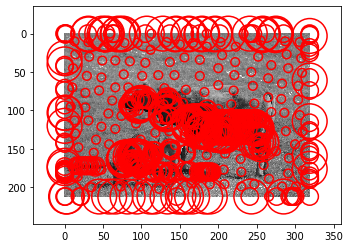

In [186]:
sigmas = [16, 8, 4] # , 2]
img_array = np.asarray(img)
m, n = img_array.shape[-2:]
kernel_size = 33
points = total_maxima_finder(
    img_array, sigmas, kernel_size, convolver=scipy_convolver,
    # thresholder=lambda x: 150
)
# Filter points near corners
#points = [
#  point for point in points if (kernel_size//2 < point[0] < m - kernel_size//2) and \
#  (kernel_size//2 < point[1] < n - kernel_size//2)
#]
print(len(points))
plot_results(img, points)

### TODO:

MA SE SI FA CON L'HASHMAP QUANTO TEMPO CI METTE?
0. Negative values!!!
1. Implement the local maximum finder
2. Implement the multiple-scale algorithm with maxima and packaging
in one image (with associated info on sigma etc for each point)
3. Plot the blobs with radius $\sigma\sqrt{2}$
4. Take 3-4 images for showing results

## Putting it all together

**TODO Scrivere!!!**

## Final Considerations
**TODO Scrivere!!!**